# Loading Packages

In [1]:
! jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

## Seaborn for plots

In [3]:
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

## Progress Bar

In [4]:
%%capture
from tqdm import tqdm_notebook
tqdm_notebook().pandas()

## Pandas Options

In [5]:
pd.set_option('max_columns', None)
pd.set_option('display.max_rows', None)

# Loading Files

## 1 - Read Default Data

In [6]:
path = '..//resources//aaa_sample_data.xlsx'

df_original = pd.read_excel(path)

* Data Glance

In [7]:
df_original.head(n=2)

,Column1,Individual Key,Household Key,Member Flag,City,State - Grouped,ZIP5,ZIP9,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag,INS Client Flag,TRV Globalware Flag,Number of Children,Responded to Catalog,Race,Length Of Residence,Mail Responder,Home Owner,Income,Date Of Birth,Children,Education,Dwelling Type,Credit Ranges,Language,Gender,Active Expiration Date,Address Change Date,Bad Address Flag,Billing Code Description,Birth Date MMDDYYYY,Branch Name,Cancel Date,Cancel Reason,County,Do Not Direct Mail Solicit,Email Available,Email Status,ERS ENT Count Year 1,ERS ENT Count Year 2,ERS ENT Count Year 3,ERS Member Cost Year 1,ERS Member Cost Year 2,ERS Member Cost Year 3,Right_Gender,Right_Individual Key,Join AAA Date,Join Club Date,Member Key,Member Map Location,Member Number Associate ID,Member Phone Type,Member Status,Member Tenure Years,Member Type,Membership ID,Months from Join to Cancel,Opt-Out - Publication,Reason Joined,Reinstate Date,Renew Method,ZIP,Mosaic Household,Mosaic Global Household,kcl_B_IND_MosaicsGrouping,New Mover Flag,Occupation Code,Occupation Group,Right_Dwelling Type,Move Distance,Occupant Type,Breakdown Map Location,Breakdown City,Breakdown State,Basic Cost,Calculated Tow Miles,Call Canceled,Call Killed,Call Status Recv Date,Cash Call,Clearing Code Last Description,Dispatch Code1 Description,Dispatch Code2Description,DTL Prob1 Code Description,Fleet Indicator,Is Duplicate,Is NSR,Member Match Flag,Member Number and Associate ID,Motorcycle Indicator,Plus Cost,Plus Indicator Description,Premier Cost,Prob1 Code Description,Prob2 Code Description,SC Call Club Code Description,SC Date,Rec ID,SC STS RSN Code Description,SC Vehicle Manufacturer Name,SC Vehicle Model Name,SVC Facility Name,SVC Facility Type,Total Cost,Tow Destination Latitude,Tow Destination Longitude,Tow Destination Name,Was Duplicated,Was Towed To AAR Referral
0,0,100000030,104625900,Y,NEW HAVEN,CT,65110,651113490,N,N,N,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,Small or large multi-family w/apt number,NaN,NaN,Male,NaT,NaT,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,522115500,45007910,Y,WEST WARWICK,RI,28930,289338500,N,Y,N,N,N,N,N,N,One Child,NaN,Caucasion / White - English,150.0,Yes,Home Owner,"30-39,999",1922-02-05,Yes,Some College,Small or large multi-family w/apt number,600-649,English,NaN,2020-09-01,2005-01-28 12:41:09,F,New Member,1922-02-05,RI - WARWICK BRANCH,NaT,NaN,KENT,0.0,0.0,NaN,0.0,0.0,20.0,0.0,0.0,650.0,NaN,522115500.0,1970-09-01,1970-09-01,15000140.0,"{41.696,-71.5308}",153000.0,VoIP,ACTIVE,490.0,Primary,1530.0,NaN,Opt-In,NaN,2019-08-23,AUTO RENEW,28930.0,Senior Discounts,Low Income Elders,Golden Year Guardians,N,NaN,NaN,NaN,NaN,NaN,"{41,-71}",West Warwick,RI,325.0,8.0,N,N,2017-04-13 10:05:17,Y,CASH CALL ONLY C,Engine Overheat,NaN,Engine Overheat,N,0.0,0.0,10.0,153000.0,N,0.0,Basic Membership,0.0,Tow,NaN,AAA Northeast,2017-04-13,97073200.0,CASH CALL ONLY C,TOYOTA,CAMRY,ASTRO WRECKER SERVICE,independent repair,325.0,410.0,-710.0,Aar / Johnson's Auto Service,0.0,10.0


* General Info

In [8]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21344 entries, 0 to 21343
Columns: 113 entries, Column1 to Was Towed To AAR Referral
dtypes: datetime64[ns](9), float64(31), int64(5), object(68)
memory usage: 18.4+ MB


In [9]:
df_original.dtypes;

# Data processing 

* Creating Dictionary to keep track of each operation and each filtering per operation

In [10]:
removed_columns = {}
removed_rows = {}

## 1 - Dropping Erroneous Column (excel did that on converting the csv original file)

In [11]:
removed_columns['Erroneous Columns Removal'] = ['Column1'] 

In [12]:
df_original.drop(columns='Column1', inplace=True)

In [13]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21344 entries, 0 to 21343
Columns: 112 entries, Individual Key to Was Towed To AAR Referral
dtypes: datetime64[ns](9), float64(31), int64(4), object(68)
memory usage: 18.2+ MB


## 2 - Grouping By Househol Key (main objective) and separate by variable type

In [14]:
binary_columns = ['FSV CMSI Flag', 'FSV Credit Card Flag', 'FSV Deposit Program Flag', 'FSV Home Equity Flag', 'FSV ID Theft Flag', 'FSV Mortgage Flag', 'INS Client Flag', 'TRV Globalware Flag', 'Responded to Catalog', 'Mail Responder', 'Home Owner', 'Children', 'Gender', 'Bad Address Flag', 'Do Not Direct Mail Solicit', 'Email Available', 'Opt-Out - Publication', 'New Mover Flag', 'Occupant Type', 'Call Canceled', 'Call Killed', 'Cash Call', 'Fleet Indicator', 'Is Duplicate', 'Is NSR',	'Member Match Flag', 'Was Duplicated',	'Was Towed To AAR Referral'] # binary data that will be threat different from the rest of the numerical and categorical data

binary = pd.DataFrame() # individual binary dataframe

binary['Household Key'] = df_original['Household Key'] # concatenating household key column to perform groupby method

numericals = pd.DataFrame() # individual numerical dataframe

string = pd.DataFrame() # individual string dataframe

string['Household Key'] = df_original['Household Key'] # concatenating household key column to perform groupby method

dates = pd.DataFrame() # individual dates dataframe

dates['Household Key'] = df_original['Household Key'] # concatenating household key column to perform groupby method

In [15]:
for c in tqdm_notebook(df_original.columns, desc='Process Progress'): # for all the columns

    if c in binary_columns: # if the columns is in the binary categorie

        binary[c] = df_original[c] # fill in the binary dataframe
    
    elif df_original.dtypes[c] in ['int64', 'float64']: # if the variables type of the given column are float or iteger

        numericals[c] = df_original[c] # fill in the numerical dataframe

    elif df_original.dtypes[c] in ['<M8[ns]']: # if the variables type of the given column are in the data format
        
        dates[c] = df_original[c] # fill in the date dataframe

    else:

        string[c] = df_original[c] # else, fill in the string dataframe
    

In [16]:
numericals = numericals.groupby('Household Key').mean() # grouping by the mean of numerical values per each Household Key

binary_numericals = binary.groupby('Household Key').mean() # grouping by the mean of binary values per each Household Key We still need to separate categorical and numerical binary variables to perform the groupby procedure in the categorical columns

In [17]:
for c in tqdm_notebook(binary.columns, desc='Process Progress'): # Separating Binary Types
    if (c != 'Household Key'): # we dont want to iterate over the Household Key unecessarily
        if (binary.dtypes[c] in ['int64', 'float64']): # if the variables type of the given column are float or iteger 

            binary.drop(columns=c, inplace=True) # dropped from the future categorical binary dataframe

In [18]:
for c in tqdm_notebook(dates.columns, desc='Process Progress'): # Converting Dates into Years
    if (c != 'Household Key'):
        dates[c] = dates[c].astype('datetime64[ns]')
        dates[c] = dates[c].dt.year
        #dates[c] = dates[c].astype('int64')

In [19]:
dates  = dates.groupby('Household Key').mean() # grouping by the mean of year values per each Household Key

In [20]:
string = string.groupby('Household Key').apply(lambda x: x.mode()) # grouping by the mode of each categorical per each Household Key

In [21]:
string.head(n=2) # by some reason, the groupby method by the mode of string columns returned a multi-index dataframe. Therefore, we need to remove the multi-index of this dataframe to move further our analysis

Household Key Member Flag      City State - Grouped  \
Household Key                                                          
8750          0         8750.0           Y  CRANSTON              RI   
              1            NaN         NaN       NaN             NaN   

                Number of Children Race Income Education Dwelling Type  \
Household Key                                                            
8750          0                NaN  NaN    NaN       NaN          SFDU   
              1                NaN  NaN    NaN       NaN           NaN   

                Credit Ranges Language Billing Code Description  \
Household Key                                                     
8750          0           NaN      NaN      Renewal Mbr Billing   
              1           NaN      NaN                      NaN   

                          Branch Name Cancel Reason      County  Email Status  \
Household Key                                                                   
8750          0  RI - CRANSTON BRANCH   Non-Payment  PROVIDENCE        Active   
              1                   NaN           NaN         NaN  Unsubscribed   

                Right_Gender Member Map Location Member Phone Type  \
Household Key                                                        
8750          0          NaN  {41.7658,-71.4978}          Wireless   
              1          NaN                 NaN               NaN   

                Member Status Member Type Reason Joined Renew Method  \
Household Key                                                          
8750          0        ACTIVE   Associate           NaN       NOTICE   
              1           NaN         NaN           NaN          NaN   

                   Mosaic Household Mosaic Global Household  \
Household Key                                                 
8750          0  Couples with Clout    Bourgeois Prosperity   
              1                 NaN                     NaN   

                kcl_B_IND_MosaicsGrouping Occupation Code Occupation Group  \
Household Key                                                                
8750          0               Power Elite             NaN              NaN   
              1                       NaN             NaN              NaN   

                Right_Dwelling Type Move Distance Breakdown Map Location  \
Household Key                                                              
8750          0   Multi Family With  1 to 5 Miles               {41,-71}   
              1                 NaN           NaN                    NaN   

                Breakdown City Breakdown State Call Status Recv Date  \
Household Key                                                          
8750          0       Cranston              RI   2014-09-27 17:54:38   
              1            NaN             NaN   2014-09-29 06:34:41   

                Clearing Code Last Description   Dispatch Code1 Description  \
Household Key                                                                 
8750          0                 Normal Service            Flat Tire w/spare   
              1                            NaN  Transmission/Clutch Failure   

                  DTL Prob1 Code Description Motorcycle Indicator  \
Household Key                                                       
8750          0            Flat Tire w/spare                    N   
              1  Transmission/Clutch Failure                  NaN   

                Plus Indicator Description Prob1 Code Description  \
Household Key                                                       
8750          0            Plus Membership                    Tow   
              1                        NaN                    NaN   

                Prob2 Code Description SC Call Club Code Description  \
Household Key                                                          
8750          0                    NaN                 AAA Northeast   
              1     

In [22]:
post_processed_string = pd.DataFrame() # creating a new dataframe for the post processed string variable

In [23]:
for house_id in tqdm_notebook(df_original['Household Key'].unique().tolist(), desc='Process Progress'): # iterating over all unique Household Keys

    if len(string.loc[house_id].index.tolist()) > 1: # if, for a given Household Key, we have more then one multi-index value

        result = string.loc[house_id].iloc[0] + string.loc[house_id].iloc[1] # we sum the first two rows

        non_null_indexes = np.where(string.loc[house_id].iloc[1].isnull().tolist())[0] # we evaluate which of them were not null before the sum procedure

        for i in np.where(string.loc[house_id].iloc[1].isnull().tolist())[0]: # we iterate over the indexes that were not null before the sum procedure

            result[i] = string.loc[house_id].iloc[0][i] # we replace by the previous non null value

        post_processed_string = pd.concat([post_processed_string, result.to_frame().T]) # and we store on our new dataframe

    else: # if, for a given Household Key, we have only one multi-index value

        result = string.loc[house_id].iloc[0] # we store it because we can not change it so far

        post_processed_string = pd.concat([post_processed_string, result.to_frame().T]) # # and we store on our new dataframe

In [24]:
post_processed_string = post_processed_string.set_index('Household Key') # set index to be sorted as Household Key values

post_processed_string.index = post_processed_string.index.astype(int) # converting the index to iterger

post_processed_string.head(n=3)

,Member Flag,City,State - Grouped,Number of Children,Race,Income,Education,Dwelling Type,Credit Ranges,Language,Billing Code Description,Branch Name,Cancel Reason,County,Email Status,Right_Gender,Member Map Location,Member Phone Type,Member Status,Member Type,Reason Joined,Renew Method,Mosaic Household,Mosaic Global Household,kcl_B_IND_MosaicsGrouping,Occupation Code,Occupation Group,Right_Dwelling Type,Move Distance,Breakdown Map Location,Breakdown City,Breakdown State,Call Status Recv Date,Clearing Code Last Description,Dispatch Code1 Description,DTL Prob1 Code Description,Motorcycle Indicator,Plus Indicator Description,Prob1 Code Description,Prob2 Code Description,SC Call Club Code Description,SC STS RSN Code Description,SC Vehicle Manufacturer Name,SC Vehicle Model Name,SVC Facility Name,SVC Facility Type,Tow Destination Name
104625900,Y,NEW HAVEN,CT,NaN,NaN,NaN,NaN,Small or large multi-family w/apt number,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45007910,Y,WEST WARWICK,RI,One Child,Caucasion / White - English,"30-39,999",Some College,Small or large multi-family w/apt number,600-649,English,New Member,RI - WARWICK BRANCH,NaN,KENT,NaN,NaN,"{41.696,-71.5308}",VoIP,ACTIVE,Primary,NaN,AUTO RENEW,Senior Discounts,Low Income Elders,Golden Year Guardians,NaN,NaN,NaN,NaN,"{41,-71}",West Warwick,RI,2015-01-29 14:34:292015-09-25 16:26:14,Normal Service,Member Requests Battery Service,Member Requests Battery Service,N,Basic Membership,Battery Service,NaN,AAA Northeast,Normal Service,TOYOTA,CAMRY,ASTRO WRECKER SERVICEAstro Wrecker Service,independent repair,Aar / Johnson's Auto Service
43175160,Y,TIVERTON,RI,NaN,NaN,NaN,NaN,SFDU,NaN,NaN,Cancellation,RI - BARRINGTON BRANCH,Deceased,NEWPORT,NaN,NaN,"{41.673,-71.1886}",NaN,CANCELLED,Primary,NaN,NOTICE,Aging in Place,Comfortable Retirement,Autumn Years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
binary_categoricals = binary.groupby('Household Key').apply(lambda x: x.mode()) # grouping by the mode of each categorical per each Household Key

In [26]:
binary_categoricals.head(n=5) # by some reason, the groupby method by the mode of binary_categoricals columns returned a multi-index dataframe. Therefore, we need to remove the multi-index of this dataframe to move further our analysis

Household Key FSV CMSI Flag FSV Credit Card Flag  \
Household Key                                                       
8750          0         8750.0             N                    N   
9690          0         9690.0             N                    N   
33380         0        33380.0             N                    N   
87180         0        87180.0             N                    N   
              1            NaN           NaN                  NaN   

                FSV Deposit Program Flag FSV Home Equity Flag  \
Household Key                                                   
8750          0                        N                    N   
9690          0                        N                    N   
33380         0                        N                    N   
87180         0                        N                    N   
              1                      NaN                  NaN   

                FSV ID Theft Flag FSV Mortgage Flag INS Client Flag  \
Household Key                                                         
8750          0                 N                 N               N   
9690          0                 N                 N               N   
33380         0                 N                 N               N   
87180         0                 N                 N               N   
              1               NaN               NaN             NaN   

                TRV Globalware Flag Responded to Catalog Mail Responder  \
Household Key                                                             
8750          0                   N                  NaN            NaN   
9690          0                   N                  NaN            Yes   
33380         0                   N                  NaN            Yes   
87180         0                   N                  NaN            Yes   
              1                   Y                  NaN            NaN   

                 Home Owner Children Gender Bad Address Flag  \
Household Key                                                  
8750          0         NaN      NaN    NaN                F   
9690          0  Home Owner       No   Male                F   
33380         0  Home Owner      Yes    NaN                F   
87180         0  Home Owner       No   Male                F   
              1         NaN      NaN    NaN              NaN   

                Opt-Out - Publication New Mover Flag Occupant Type  \
Household Key                                                        
8750          0                Opt-In              N        Renter   
9690          0                Opt-In              N           NaN   
33380         0                Opt-In              N           NaN   
87180         0                Opt-In              N           NaN   
              1                   NaN            NaN           NaN   

                Call Canceled Call Killed Cash Call Fleet Indicator  
Household Key                                                        
8750          0             N           N         N               Y  
9690          0             N           N         N               Y  
33380         0           NaN         NaN       NaN             NaN  
87180         0           NaN         NaN       NaN             NaN  
              1           NaN         NaN       NaN             NaN

In [27]:
post_processed_binary_categoricals = pd.DataFrame() # creating a new dataframe for the post processed string variable

In [28]:
for house_id in tqdm_notebook(df_original['Household Key'].unique().tolist(), desc='Process Progress'): # iterating over all unique Household Keys

    if len(binary_categoricals.loc[house_id].index.tolist()) > 1: # if, for a given Household Key, we have more then one multi-index value

        result = binary_categoricals.loc[house_id].iloc[0] + binary_categoricals.loc[house_id].iloc[1] # we sum the first two rows

        non_null_indexes = np.where(binary_categoricals.loc[house_id].iloc[1].isnull().tolist())[0] # we evaluate which of them were not null before the sum procedure

        for i in np.where(binary_categoricals.loc[house_id].iloc[1].isnull().tolist())[0]: # we iterate over the indexes that were not null before the sum procedure

            result[i] = binary_categoricals.loc[house_id].iloc[0][i] # we replace by the previous non null value

        post_processed_binary_categoricals = pd.concat([post_processed_binary_categoricals, result.to_frame().T]) # and we store on our new dataframe

    else: # if, for a given Household Key, we have only one multi-index value

        result = binary_categoricals.loc[house_id].iloc[0] # we store it because we can not change it so far

        post_processed_binary_categoricals = pd.concat([post_processed_binary_categoricals, result.to_frame().T]) # # and we store on our new dataframe

In [29]:
post_processed_binary_categoricals = post_processed_binary_categoricals.set_index('Household Key') # set index to be sorted as Household Key values

post_processed_binary_categoricals.index = post_processed_binary_categoricals.index.astype(int) # converting the index to iterger

post_processed_binary_categoricals.head(n=3)

,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag,INS Client Flag,TRV Globalware Flag,Responded to Catalog,Mail Responder,Home Owner,Children,Gender,Bad Address Flag,Opt-Out - Publication,New Mover Flag,Occupant Type,Call Canceled,Call Killed,Cash Call,Fleet Indicator
104625900,N,N,N,N,N,N,N,N,NaN,NaN,NaN,NaN,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45007910,N,Y,N,N,N,N,N,N,NaN,Yes,Home Owner,Yes,NaN,F,Opt-In,N,NaN,N,N,N,N
43175160,N,N,N,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,F,Opt-In,N,NaN,NaN,NaN,NaN,NaN


In [30]:
print(len(numericals.index), len(binary_numericals.index), len(post_processed_binary_categoricals.index), len(dates.index), len(post_processed_string.index)) # number of rows per type of variable

5241 5241 5241 5241 5241


In [31]:
print(len(numericals.columns), len(binary_numericals.columns), len(post_processed_binary_categoricals.columns), len(dates.columns), len(post_processed_string.columns)) # number of columns per type of variable

27 7 21 9 47


## 3 - Evaluating number of null values in Columns (Data Processing)

In [32]:
columns_nullval_ratio = {} # dictionary of null values ration for all columns

sequence = ['Numerical', 'Binary Numericals', 'Dates', 'Binary Categoricals', 'Strings'] # key sequence for dictionaries

data_type_collection = [numericals, binary_numericals, dates, post_processed_binary_categoricals, post_processed_string] # list of dataframes per each data type

for var_type, idx in zip(sequence, range(len(sequence))): 

    columns_nullval_ratio[var_type] = (data_type_collection[idx].isnull().sum() * 100 / len(data_type_collection[idx])).sort_values(ascending=False) # filling dataframe dictionary

plt.figure(figsize=(10,5))
sns.barplot(x=columns_nullval_ratio[sequence[0]].index, y=columns_nullval_ratio[sequence[0]])
plt.xticks(rotation='90')
plt.xlabel('Variables', fontsize=10)
plt.ylabel('Percentage of missing values', fontsize=10)
plt.title('Percentage of missing values for the' + ' ' + sequence[0] + ' ' + 'Dataframe', fontsize=15)

plt.figure(figsize=(10,5))

sns.barplot(x=columns_nullval_ratio[sequence[1]].index, y=columns_nullval_ratio[sequence[1]])
plt.xticks(rotation='90')
plt.xlabel('Variables', fontsize=10)
plt.ylabel('Percentage of missing values', fontsize=10)
plt.title('Percentage of missing values for the' + ' ' + sequence[1] + ' ' + 'Dataframe', fontsize=15)

plt.figure(figsize=(10,5))

sns.barplot(x=columns_nullval_ratio[sequence[2]].index, y=columns_nullval_ratio[sequence[2]])
plt.xticks(rotation='90')
plt.xlabel('Variables', fontsize=10)
plt.ylabel('Percentage of missing values', fontsize=10)
plt.title('Percentage of missing values for the' + ' ' + sequence[2] + ' ' + 'Dataframe', fontsize=15)

plt.figure(figsize=(10,5))

sns.barplot(x=columns_nullval_ratio[sequence[3]].index, y=columns_nullval_ratio[sequence[3]])
plt.xticks(rotation='90')
plt.xlabel('Variables', fontsize=10)
plt.ylabel('Percentage of missing values', fontsize=10)
plt.title('Percentage of missing values for the' + ' ' + sequence[3] + ' ' + 'Dataframe', fontsize=15)

plt.figure(figsize=(10,5))

sns.barplot(x=columns_nullval_ratio[sequence[4]].index, y=columns_nullval_ratio[sequence[4]])
plt.xticks(rotation='90')
plt.xlabel('Variables', fontsize=10)
plt.ylabel('Percentage of missing values', fontsize=10)
plt.title('Percentage of missing values for the' + ' ' + sequence[4] + ' ' + 'Dataframe', fontsize=15)

In [33]:
checkpoint_1 = {} # creating dictionary for the first checkpoint

for var_type, idx in zip(sequence, range(len(sequence))): 
    checkpoint_1[var_type] = data_type_collection[idx].copy() # filling it with all types of dataframes

In [34]:
column_threshold = 40.0 # threshold of 40 %

In [35]:
key2 = str(column_threshold) + '% Column Threshold Removal' # key for our track removal dictionary

removed_columns[key2] = [] # adding to the new key to the dictionary

In [36]:
for c in tqdm_notebook(df_original.columns, desc='Process Progress'): # for all columns on the original dataframe
    for var_type in sequence: # for all type of separatable dataframe 

        if c in checkpoint_1[var_type].columns: # if the column is in the list of columns of the given type of dataframe

            if columns_nullval_ratio[var_type][c] >= column_threshold: # we check if the same does not satisfies the threshold limit

                checkpoint_1[var_type].drop(columns=c, inplace=True) # in this case we remove the given column from the given type of dataframe
                
                removed_columns[key2].append(c) # and we add its name to the list of removed columns

print('Removed Columns after filtering process: ', removed_columns[key2])


Removed Columns after filtering process:  ['Responded to Catalog', 'Gender', 'Address Change Date', 'Right_Gender', 'Reason Joined', 'Reinstate Date', 'Occupation Code', 'Occupation Group', 'Right_Dwelling Type', 'Move Distance', 'Occupant Type', 'Dispatch Code2Description', 'Prob2 Code Description', 'Tow Destination Name']


In [37]:
for var_type, idx in zip(sequence, range(len(sequence))): # lets check the result now

    columns_nullval_ratio[var_type] = (checkpoint_1[var_type].isnull().sum() * 100 / len(checkpoint_1[var_type])).sort_values(ascending=False) # filling dataframe dictionary

plt.figure(figsize=(10,5))

sns.barplot(x=columns_nullval_ratio[sequence[0]].index, y=columns_nullval_ratio[sequence[0]])
plt.xticks(rotation='90')
plt.xlabel('Variables', fontsize=10)
plt.ylabel('Percentage of missing values', fontsize=10)
plt.title('Percentage of missing values for the' + ' ' + sequence[0] + ' ' + 'Dataframe', fontsize=15)

plt.figure(figsize=(10,5))

sns.barplot(x=columns_nullval_ratio[sequence[1]].index, y=columns_nullval_ratio[sequence[1]])
plt.xticks(rotation='90')
plt.xlabel('Variables', fontsize=10)
plt.ylabel('Percentage of missing values', fontsize=10)
plt.title('Percentage of missing values for the' + ' ' + sequence[1] + ' ' + 'Dataframe', fontsize=15)

plt.figure(figsize=(10,5))

sns.barplot(x=columns_nullval_ratio[sequence[2]].index, y=columns_nullval_ratio[sequence[2]])
plt.xticks(rotation='90')
plt.xlabel('Variables', fontsize=10)
plt.ylabel('Percentage of missing values', fontsize=10)
plt.title('Percentage of missing values for the' + ' ' + sequence[2] + ' ' + 'Dataframe', fontsize=15)

plt.figure(figsize=(10,5))

sns.barplot(x=columns_nullval_ratio[sequence[3]].index, y=columns_nullval_ratio[sequence[3]])
plt.xticks(rotation='90')
plt.xlabel('Variables', fontsize=10)
plt.ylabel('Percentage of missing values', fontsize=10)
plt.title('Percentage of missing values for the' + ' ' + sequence[3] + ' ' + 'Dataframe', fontsize=15)

plt.figure(figsize=(10,5))

sns.barplot(x=columns_nullval_ratio[sequence[4]].index, y=columns_nullval_ratio[sequence[4]])
plt.xticks(rotation='90')
plt.xlabel('Variables', fontsize=10)
plt.ylabel('Percentage of missing values', fontsize=10)
plt.title('Percentage of missing values for the' + ' ' + sequence[4] + ' ' + 'Dataframe', fontsize=15)

## 4 - Subjective Evaluation (Data Processing)

    4.1 - Rename FSV, INS, and TRV columns that are related to products purchase flags

In [38]:
matching_FSV = [s for s in list(checkpoint_1['Binary Categoricals'].columns) if "FSV" in s] # creating a list of the columns that have at least the FSV mnemonic
matching_INS = [s for s in list(checkpoint_1['Binary Categoricals'].columns) if "INS" in s] # creating a list of the columns that have at least the INS mnemonic
matching_TRV = [s for s in list(checkpoint_1['Binary Categoricals'].columns) if "TRV" in s] # creating a list of the columns that have at least the TRV mnemonic
final_matching = matching_FSV + matching_INS + matching_TRV # concatenating them all
print(final_matching)

['FSV CMSI Flag', 'FSV Credit Card Flag', 'FSV Deposit Program Flag', 'FSV Home Equity Flag', 'FSV ID Theft Flag', 'FSV Mortgage Flag', 'INS Client Flag', 'TRV Globalware Flag']


In [39]:
counter = 1 # counter flag

for c in final_matching:

    checkpoint_1['Binary Categoricals'].rename(columns={c : 'Purchased Product' + ' ' + str(counter)}, inplace=True) # renaming the columns

    counter = counter + 1 # index of the new product column name

In [40]:
checkpoint_1['Binary Categoricals'].head(n=2)

,Purchased Product 1,Purchased Product 2,Purchased Product 3,Purchased Product 4,Purchased Product 5,Purchased Product 6,Purchased Product 7,Purchased Product 8,Mail Responder,Home Owner,Children,Bad Address Flag,Opt-Out - Publication,New Mover Flag,Call Canceled,Call Killed,Cash Call,Fleet Indicator
104625900,N,N,N,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45007910,N,Y,N,N,N,N,N,N,Yes,Home Owner,Yes,F,Opt-In,N,N,N,N,N


    4.2 -  Removing columns that are not allowed or not ethical to work


        4.2.1 - Creating Dictionary Key

In [41]:
key3 = 'Unethical Columns' # creating key to removed columns

removed_columns[key3] = ['Race', 'Language', 'Gender'] # since we are talking about Households, the same can not be differentiate by gender

        4.2.2 - Performing Filtering

In [42]:
for c in tqdm_notebook(removed_columns[key3], desc='Process Progress'): # iterating over the given columns
    for var_type in sequence: # for each dataframe type
        if c in checkpoint_1[var_type]: # if the columns is in the dataframe

            checkpoint_1[var_type].drop(columns=c, inplace=True) # we dropped

print('Removed Columns after filtering process: ', removed_columns[key3])


Removed Columns after filtering process:  ['Race', 'Language', 'Gender']


    4.3 - Removing Columns that represent the same information in a different way (information redundancy)

        4.3.1 - Creating Dictionary Key

In [43]:
key4 = 'Redundancy Information Columns' # generating key for this filtering procedure

removed_columns[key4] = ['Individual Key', 'State - Grouped', 'ZIP5', 'ZIP9', 'Children', 'Birth Date MMDDYYYY', 'Cancel Date', 'County', 'Do Not Direct Mail Solicit', 'Right_Individual Key', 'Member Key', 'Member Number Associate ID', 'Membership ID', 'Reinstate Date', 'ZIP', 'Mosaic Household', 'kcl_B_IND_MosaicsGrouping', 'Breakdown State', 'Call Killed', 'Clearing Code Last Description', 'Dispatch Code1 Description','DTL Prob1 Code Description', 'Is Duplicate', 'Member Match Flag', 'Member Number and Associate ID', 'SC Date', 'Rec ID', 'SC STS RSN Code Description', 'SC Vehicle Model Name', 'SVC Facility Name', 'SVC Facility Type', 'Tow Destination Latitude', 'Tow Destination Longitude', 'Member Map Location', 'Dwelling Type', 'Email Status', 'Cancel Reason', 'Breakdown City', 'Call Status Recv Date', 'Occupation Group'] #  Comlumns ids

        4.3.2 - Performing Filtering

In [44]:
for c in tqdm_notebook(removed_columns[key4], desc='Process Progress'): # for each column in the redundancy columns list
    for var_type in sequence: # for each dataframe type
        if c in checkpoint_1[var_type]: # if the columns is in the given dataframe
            checkpoint_1[var_type].drop(columns=c, inplace=True) # we dropped

print('Removed Columns after filtering process: ', removed_columns[key4])


Removed Columns after filtering process:  ['Individual Key', 'State - Grouped', 'ZIP5', 'ZIP9', 'Children', 'Birth Date MMDDYYYY', 'Cancel Date', 'County', 'Do Not Direct Mail Solicit', 'Right_Individual Key', 'Member Key', 'Member Number Associate ID', 'Membership ID', 'Reinstate Date', 'ZIP', 'Mosaic Household', 'kcl_B_IND_MosaicsGrouping', 'Breakdown State', 'Call Killed', 'Clearing Code Last Description', 'Dispatch Code1 Description', 'DTL Prob1 Code Description', 'Is Duplicate', 'Member Match Flag', 'Member Number and Associate ID', 'SC Date', 'Rec ID', 'SC STS RSN Code Description', 'SC Vehicle Model Name', 'SVC Facility Name', 'SVC Facility Type', 'Tow Destination Latitude', 'Tow Destination Longitude', 'Member Map Location', 'Dwelling Type', 'Email Status', 'Cancel Reason', 'Breakdown City', 'Call Status Recv Date', 'Occupation Group']


In [45]:
for var_type in sequence:

    print(var_type + ':', len(checkpoint_1[var_type].columns)) # number of remaining columns for each dataframe type after the filtering process 

Numerical: 14
Binary Numericals: 4
Dates: 4
Binary Categoricals: 16
Strings: 19


    4.4 - Checking Columns with low percentage of variantional information (counting null values)

        4.4.1 - Creating Dictionay Key 

In [46]:
key5 = 'Low Variational Information Columns' # generating key for this filtering procedure

removed_columns[key5] = [] # generating empty list

        4.4.2 - Performing Filtering

In [47]:
for var_type in tqdm_notebook(sequence, desc='Process Progress'): # for every dataframe type
    for c in checkpoint_1[var_type].columns: # for every column in the given dataframe

        if checkpoint_1[var_type].nunique()[c] == 1: # we check if the values on the given column are all the same

            checkpoint_1[var_type].drop(columns=c, inplace=True) # if it is so, we drop the column

            removed_columns[key5].append(c) # and we fill the removed columns list
        
print('Removed Columns after filtering process: ', removed_columns[key5])


Removed Columns after filtering process:  ['Member Flag']


In [48]:
for var_type in sequence:

    print(var_type + ':', len(checkpoint_1[var_type].columns)) # number of remaining columns for each dataframe type after the filtering process 

Numerical: 14
Binary Numericals: 4
Dates: 4
Binary Categoricals: 16
Strings: 18


    4.5 - Removing Columns with Unnecessary Information (extremely subjective)

        4.5.1 - Creating Dictionary Key

In [49]:
key6 = 'Unnecessary Columns' # generating key for this filtering procedure

removed_columns[key6] = ['Address Change Date', 'Bad Address Flag', 'Billing Code Description', 'Join Club Date', 'Member Phone Type', 'Mosaic Global Household', 'New Mover Flag', 'Call Canceled', 'Is NSR', 'Plus Indicator Description', 'Was Duplicated', 'Was Towed To AAR Referral', 'Branch Name', 'Member Map Location', 'Breakdown Map Location'] #  Comlumns ids

        4.5.2 - Performing Filtering

In [50]:
for c in tqdm_notebook(removed_columns[key6], desc='Process Progress'): # for each column in the unncessary columns list
    for var_type in sequence: # for each dataframe type

        if c in checkpoint_1[var_type]: # if the column is in the given dataframe
            checkpoint_1[var_type].drop(columns=c, inplace=True) # we dropped

print('Removed Columns after filtering process: ', removed_columns[key6])


Removed Columns after filtering process:  ['Address Change Date', 'Bad Address Flag', 'Billing Code Description', 'Join Club Date', 'Member Phone Type', 'Mosaic Global Household', 'New Mover Flag', 'Call Canceled', 'Is NSR', 'Plus Indicator Description', 'Was Duplicated', 'Was Towed To AAR Referral', 'Branch Name', 'Member Map Location', 'Breakdown Map Location']


In [51]:
for var_type in sequence:

    print(var_type + ':', len(checkpoint_1[var_type].columns)) # number of remaining columns for each dataframe type after the filtering process 

Numerical: 14
Binary Numericals: 1
Dates: 3
Binary Categoricals: 13
Strings: 12


## 5 - Null value evaluation for each Household Key (Data Processing)

    5.1 - Removing rows (Household Keys) beyond given threshold

        5.1.1 - Global Mean of Null Values for all Household Keys available

In [52]:
rows_nullval_ratio = {} # dictionary of null values sum for all columns

for var_type in sequence: 

    rows_nullval_ratio[var_type] = (checkpoint_1[var_type].isnull().sum(axis=1).sort_values(ascending=False)) # filling dataframe dictionary

In [53]:
sum_num_null_rows = [] # list of sum of all null values per row

for var_type in sequence:

    sum_num_null_rows.append(round(rows_nullval_ratio[var_type].sum())) # filling list

total_mean = round(sum(sum_num_null_rows)/len(rows_nullval_ratio['Numerical'].index.tolist())) # general mean of null values per row

print('\n','Mean Number of Null values on Rows:', total_mean) 


 Mean Number of Null values on Rows: 8.0


        5.1.2 - Creating Key and Dictionary for this operation

In [54]:
removed_rows = {}

row_key1 = str(total_mean) + ' Number of Null per Row Threshold Removal' # key for our track removal dictionary

removed_rows[row_key1] = [] # adding to the new key to the dictionary

        5.1.3 - Global Mean of each Household Key available

In [55]:
house_mean = {} # global mean number of null values for each Household Key

for house_id in tqdm_notebook(checkpoint_1[sequence[0]].index.tolist(), desc='Process Progress'): # for all unique Household Keys on the original dataframe
    tmp = 0 # temporary value for each global mean of the given Household Key
    for var_type in sequence: # for all type of separatable dataframe 

        tmp += rows_nullval_ratio[var_type][house_id]

    house_mean[house_id] =  tmp.mean()

        5.1.4 - Perform Filtering

In [56]:
for house_id in tqdm_notebook(checkpoint_1[sequence[0]].index.tolist(), desc='Process Progress'): # for all unique Household Keys on the original dataframe
    for var_type in sequence: # for all type of separatable dataframe        
        if house_mean[house_id] >= (total_mean * 2): # we check if the same does not satisfies the threshold limit

            for var_type in sequence: # for all type of separatable dataframe 

                if house_id in checkpoint_1[var_type].index.tolist(): # check if Household Key has not been already droped to prevent error raise

                    checkpoint_1[var_type].drop(house_id, inplace=True) # drop the row related to the given Household Key in all dataframes type

                    removed_rows[row_key1].append(house_id) # and we add its name to the list of removed columns

print('Removed Rows after filtering process: ', removed_rows[row_key1])


Removed Rows after filtering process:  [208500, 208500, 208500, 208500, 208500, 253650, 253650, 253650, 253650, 253650, 374680, 374680, 374680, 374680, 374680, 949270, 949270, 949270, 949270, 949270, 1152890, 1152890, 1152890, 1152890, 1152890, 1153460, 1153460, 1153460, 1153460, 1153460, 1401850, 1401850, 1401850, 1401850, 1401850, 1434580, 1434580, 1434580, 1434580, 1434580, 1797300, 1797300, 1797300, 1797300, 1797300, 1956800, 1956800, 1956800, 1956800, 1956800, 2686980, 2686980, 2686980, 2686980, 2686980, 2690970, 2690970, 2690970, 2690970, 2690970, 2954970, 2954970, 2954970, 2954970, 2954970, 2956820, 2956820, 2956820, 2956820, 2956820, 2968010, 2968010, 2968010, 2968010, 2968010, 2977460, 2977460, 2977460, 2977460, 2977460, 3253520, 3253520, 3253520, 3253520, 3253520, 3530390, 3530390, 3530390, 3530390, 3530390, 3828020, 3828020, 3828020, 3828020, 3828020, 3830820, 3830820, 3830820, 3830820, 3830820, 3831090, 3831090, 3831090, 3831090, 3831090, 3836860, 3836860, 3836860, 3836860

In [57]:
for var_type, idx in zip(sequence, range(len(sequence))): # lets check the result now

    rows_nullval_ratio[var_type] = (checkpoint_1[var_type].isnull().sum(axis=1).sort_values(ascending=False)) # filling dataframe dictionary

In [58]:
for var_type in sequence:

    print(var_type + ':', len(checkpoint_1[var_type].index)) # total number of rows in each type of dataframe

Numerical: 4095
Binary Numericals: 4095
Dates: 4095
Binary Categoricals: 4095
Strings: 4095


In [59]:
for var_type in sequence:

    print(var_type + ':', len(checkpoint_1[var_type].columns)) # number of remaining columns for each dataframe type after the filtering process 

Numerical: 14
Binary Numericals: 1
Dates: 3
Binary Categoricals: 13
Strings: 12


## 6 - Summarize Information and Fill Nulls in the given columns 

    6.1 - Saving checkpoint 

In [60]:
checkpoint_2 = {} # creating dictionary for the second checkpoint

for var_type, idx in zip(sequence, range(len(sequence))): 
    checkpoint_2[var_type] = checkpoint_1[var_type].copy() # filling in with all dataframe types

    6.2 - Dealing first with the Numericals Dataframe

In [61]:
checkpoint_2[sequence[0]].head(n=3) # lets remember what variables and how do they behave on this dataframe

,Length Of Residence,ERS ENT Count Year 1,ERS ENT Count Year 2,ERS ENT Count Year 3,ERS Member Cost Year 1,ERS Member Cost Year 2,ERS Member Cost Year 3,Member Tenure Years,Months from Join to Cancel,Basic Cost,Calculated Tow Miles,Plus Cost,Premier Cost,Total Cost
Household Key,,,,,,,,,,,,,,
8750,NaN,7.857143,4.285714,7.142857,4623.928571,2522.142857,5472.0,289.444444,1577.5,1250.357143,80.142857,265.714286,0.0,1516.071429
9690,140.0,0.000000,6.666667,15.000000,0.000000,1470.833333,15059.5,353.333333,NaN,3072.500000,22.500000,127.500000,0.0,4347.500000
33380,50.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,373.333333,3120.0,NaN,NaN,NaN,NaN,NaN


        6.2.1 - Lets take a look at the Length Of Residence variable

In [62]:
checkpoint_2[sequence[0]]['Length Of Residence'].unique() # total number of null values for the Length Of Residence variable

array([         nan, 140.        ,  50.        , 150.        ,
       121.42857143, 116.66666667,  21.25      , 103.33333333,
       130.        ,  90.        ,  96.        ,  75.        ,
       105.        ,  80.        ,  27.85714286, 133.33333333,
        92.5       , 110.        ,  70.        , 108.33333333,
       100.        ,   0.        ,  20.        , 112.5       ,
       136.66666667,  10.        ,  60.        , 120.        ,
       141.25      , 126.66666667,  26.66666667, 165.        ,
       122.77777778, 114.28571429,  98.        ,  86.        ,
       196.66666667,  45.        ,  91.42857143, 142.72727273,
       200.        , 128.        ,  40.        , 138.57142857,
       152.85714286,  42.        ,  94.11764706, 106.42857143,
       137.14285714,  15.        , 121.66666667,  72.        ,
        42.5       ,  30.        , 124.        , 117.5       ,
       142.85714286, 132.5       , 122.5       ,  94.61538462,
       263.33333333, 290.        , 131.25      , 106.  

            6.2.2.1 - Round the values and converting them to interger type to prevent any error

In [63]:
for idx in tqdm_notebook(checkpoint_2[sequence[0]]['Length Of Residence'].index, desc='Process Progress'): # for all indexes of the given dataframe

    checkpoint_2[sequence[0]].at[idx, 'Length Of Residence'] = round(checkpoint_2[sequence[0]]['Length Of Residence'][idx]) # replace de Null value by the Household Key mean

    if np.isnan(checkpoint_2[sequence[0]]['Length Of Residence'][idx]):

        checkpoint_2[sequence[0]].at[idx, 'Length Of Residence'] = 0

# checkpoint_2[sequence[0]]['Length Of Residence'] = checkpoint_2[sequence[0]]['Length Of Residence'].astype(int)

In [64]:
Counter(checkpoint_2[sequence[0]]['Length Of Residence'].tolist());

    As we can see, we still have a considerable amount of null values in the Length Of Residence variable. If we replaced these values by the mean of the variable we would be disregarding the geographical relation. Therefore, we will use the mean related to the City variable to predict the null values

In [65]:
checkpoint_2['Strings']['City'].isnull().sum() # number of Household Keys with null City values

0

In [66]:
checkpoint_2[sequence[0]]['City'] = checkpoint_2['Strings']['City'].values # temporarily concatenate the city column on the numerical column

                6.2.2.2 - Luckly, we can rely on the City variable, stored at the Strings dataframe. Thus, we can proceed with the Null values prediction

In [67]:
for idx in tqdm_notebook(checkpoint_2[sequence[0]].index, desc='Process Progress'): # For all Household Keys

    if checkpoint_2[sequence[0]]['Length Of Residence'][idx] == 0: # we check if the Length of Residence variable is equal zero (previouly changed from nan values)

        tmp_city = checkpoint_2[sequence[0]]['City'][idx] # we store a temporary value of the city for the given Household Key

        checkpoint_2[sequence[0]]['Length Of Residence'][idx] = checkpoint_2[sequence[0]]['Length Of Residence'].loc[checkpoint_2[sequence[0]]['City'] == tmp_city].values.mean() # replacing zeroed value by mean of the Length of Residence per grouped by City

In [68]:
checkpoint_2[sequence[0]].head(n=2)

,Length Of Residence,ERS ENT Count Year 1,ERS ENT Count Year 2,ERS ENT Count Year 3,ERS Member Cost Year 1,ERS Member Cost Year 2,ERS Member Cost Year 3,Member Tenure Years,Months from Join to Cancel,Basic Cost,Calculated Tow Miles,Plus Cost,Premier Cost,Total Cost,City
Household Key,,,,,,,,,,,,,,,
8750,90.558333,7.857143,4.285714,7.142857,4623.928571,2522.142857,5472.0,289.444444,1577.5,1250.357143,80.142857,265.714286,0.0,1516.071429,WEST WARWICK
9690,140.000000,0.000000,6.666667,15.000000,0.000000,1470.833333,15059.5,353.333333,NaN,3072.500000,22.500000,127.500000,0.0,4347.500000,WARWICK


                6.2.2.3 - Droping City variable from Numerical dataframe type

In [69]:
checkpoint_2[sequence[0]].drop(columns='City', inplace=True)

        6.2.3 - Rename ERS ENT columns that are related to number of roadside calls and creating a column that presents the sum of it

            6.2.3.1 Finding given columns

In [70]:
matching_ERS_ENT = [s for s in list(checkpoint_2[sequence[0]].columns) if "ERS ENT" in s] # creating a list of the columns that have at least the ERS ENT mnemonic

print(matching_ERS_ENT)

['ERS ENT Count Year 1', 'ERS ENT Count Year 2', 'ERS ENT Count Year 3']


            6.2.3.2 Renaming Columns

In [71]:
counter = 1 # counter flag

for c in matching_ERS_ENT:

    checkpoint_2[sequence[0]].rename(columns={c : 'Number of Roadside calss for Year' + ' ' + str(counter)}, inplace=True) # renaming the columns

    counter = counter + 1 # index of the new product column name

In [72]:
checkpoint_2[sequence[0]].head(n=2)

,Length Of Residence,Number of Roadside calss for Year 1,Number of Roadside calss for Year 2,Number of Roadside calss for Year 3,ERS Member Cost Year 1,ERS Member Cost Year 2,ERS Member Cost Year 3,Member Tenure Years,Months from Join to Cancel,Basic Cost,Calculated Tow Miles,Plus Cost,Premier Cost,Total Cost
Household Key,,,,,,,,,,,,,,
8750,90.558333,7.857143,4.285714,7.142857,4623.928571,2522.142857,5472.0,289.444444,1577.5,1250.357143,80.142857,265.714286,0.0,1516.071429
9690,140.000000,0.000000,6.666667,15.000000,0.000000,1470.833333,15059.5,353.333333,NaN,3072.500000,22.500000,127.500000,0.0,4347.500000


            4.1.2.3 - Calculating Total Amount of Calls

In [73]:
new_column = [] # creating list for the new column to be appended

for idx in tqdm_notebook(checkpoint_2[sequence[0]].index, desc='Process Progress'): # For each row
    
    total_amount = 0 # total amount of calls for each Household Key

    for c in ['Number of Roadside calss for Year 1', 'Number of Roadside calss for Year 2',	'Number of Roadside calss for Year 3']: # for each Number of Roadside calls for each Year

        if np.isnan(checkpoint_2[sequence[0]][c][idx]): # checking for nan values existance

            checkpoint_2[sequence[0]].at[idx, c] = 0 # replacing them by zero calls
                  
        checkpoint_2[sequence[0]].at[idx, c] = round(checkpoint_2[sequence[0]][c][idx]) # rounding the call values

        total_amount += checkpoint_2[sequence[0]][c][idx] # summing the total amount of call

    new_column.append(total_amount) # appending to list representing the new column to be appended

In [74]:
for c in ['Number of Roadside calss for Year 1', 'Number of Roadside calss for Year 2',	'Number of Roadside calss for Year 3']: # for each Number of Roadside calls for each Year
    checkpoint_2[sequence[0]][c] = checkpoint_2[sequence[0]][c].astype(int) # converting the final values to iterger type


In [75]:
column_name = 'Total Number of Roadside Calls' # naming the new column

checkpoint_2[sequence[0]][column_name] = new_column # appendding new column

checkpoint_2[sequence[0]][column_name] = checkpoint_2[sequence[0]][column_name].astype(int) # converting to iterger type

In [76]:
checkpoint_2[sequence[0]].head(n=2)

,Length Of Residence,Number of Roadside calss for Year 1,Number of Roadside calss for Year 2,Number of Roadside calss for Year 3,ERS Member Cost Year 1,ERS Member Cost Year 2,ERS Member Cost Year 3,Member Tenure Years,Months from Join to Cancel,Basic Cost,Calculated Tow Miles,Plus Cost,Premier Cost,Total Cost,Total Number of Roadside Calls
Household Key,,,,,,,,,,,,,,,
8750,90.558333,8,4,7,4623.928571,2522.142857,5472.0,289.444444,1577.5,1250.357143,80.142857,265.714286,0.0,1516.071429,19
9690,140.000000,0,7,15,0.000000,1470.833333,15059.5,353.333333,NaN,3072.500000,22.500000,127.500000,0.0,4347.500000,22


        4.1.3 - Rename ERS Member that are related to the cost of roadside services per year and creating a column that presents the sum of it

            4.1.3.1 Finding given columns

In [77]:
matching_ERS_Cost = [s for s in list(checkpoint_2[sequence[0]].columns) if "ERS Member" in s] # creating a list of the columns that have at least the ERS Member mnemonic

print(matching_ERS_Cost)

['ERS Member Cost Year 1', 'ERS Member Cost Year 2', 'ERS Member Cost Year 3']


            4.1.3.2 Renaming Columns

In [78]:
counter = 1 # counter flag

for c in matching_ERS_Cost:

    checkpoint_2[sequence[0]].rename(columns={c : 'Roadside Member Cost for Year' + ' ' + str(counter)}, inplace=True) # renaming the columns

    counter = counter + 1 # index of the new product column name

In [79]:
checkpoint_2[sequence[0]].head(n=2)

,Length Of Residence,Number of Roadside calss for Year 1,Number of Roadside calss for Year 2,Number of Roadside calss for Year 3,Roadside Member Cost for Year 1,Roadside Member Cost for Year 2,Roadside Member Cost for Year 3,Member Tenure Years,Months from Join to Cancel,Basic Cost,Calculated Tow Miles,Plus Cost,Premier Cost,Total Cost,Total Number of Roadside Calls
Household Key,,,,,,,,,,,,,,,
8750,90.558333,8,4,7,4623.928571,2522.142857,5472.0,289.444444,1577.5,1250.357143,80.142857,265.714286,0.0,1516.071429,19
9690,140.000000,0,7,15,0.000000,1470.833333,15059.5,353.333333,NaN,3072.500000,22.500000,127.500000,0.0,4347.500000,22


            4.1.3.3 - Calculating Total Amount of Calls

In [80]:
new_column = [] # creating list for the new column to be appended

for idx in tqdm_notebook(checkpoint_2[sequence[0]].index, desc='Process Progress'): # For each row
    
    total_amount = 0 # total amount of Roadside cost for each Household Key

    for c in ['Roadside Member Cost for Year 1', 'Roadside Member Cost for Year 2',	'Roadside Member Cost for Year 3']: # for each cost of Roadside for each Year

        if np.isnan(checkpoint_2[sequence[0]][c][idx]): # checking for nan values existance

            checkpoint_2[sequence[0]].at[idx, c] = 0 # replacing them by zero cost
                  
        total_amount += checkpoint_2[sequence[0]][c][idx] # summing the total amount of roadside cost

    new_column.append(total_amount) # appending to list representing the new column to be appended

In [81]:
column_name = 'Total Roadside Member Cost' # naming the new column

checkpoint_2[sequence[0]][column_name] = new_column # appendding new column

In [82]:
checkpoint_2[sequence[0]].head(n=2)

,Length Of Residence,Number of Roadside calss for Year 1,Number of Roadside calss for Year 2,Number of Roadside calss for Year 3,Roadside Member Cost for Year 1,Roadside Member Cost for Year 2,Roadside Member Cost for Year 3,Member Tenure Years,Months from Join to Cancel,Basic Cost,Calculated Tow Miles,Plus Cost,Premier Cost,Total Cost,Total Number of Roadside Calls,Total Roadside Member Cost
Household Key,,,,,,,,,,,,,,,,
8750,90.558333,8,4,7,4623.928571,2522.142857,5472.0,289.444444,1577.5,1250.357143,80.142857,265.714286,0.0,1516.071429,19,12618.071429
9690,140.000000,0,7,15,0.000000,1470.833333,15059.5,353.333333,NaN,3072.500000,22.500000,127.500000,0.0,4347.500000,22,16530.333333


        4.1.4 - Converting Months to Join to Cancel to Years left for subscription to end

            4.1.4.1 - Renaming Column

In [83]:
checkpoint_2[sequence[0]].rename(columns={'Months from Join to Cancel' : 'Years to Cancelled Status'}, inplace=True) # renaming the column

            4.1.4.2 - Converting Months to Years

In [84]:
for idx in tqdm_notebook(checkpoint_2[sequence[0]].index, desc='Process Progress'): # For each row
    
    if ~np.isnan(checkpoint_2[sequence[0]]['Years to Cancelled Status'][idx]): # if the given Household Key does not have a null value for the given column
    
        checkpoint_2[sequence[0]].at[idx, 'Years to Cancelled Status'] = round(checkpoint_2[sequence[0]]['Years to Cancelled Status'][idx]/12) # converting months to years

            4.1.4.3 - Fill Null Values

In [85]:
mean_year = round(checkpoint_2[sequence[0]]['Years to Cancelled Status'].values[~np.isnan(checkpoint_2[sequence[0]]['Years to Cancelled Status'].values)].mean()) # mean year to cancelled status for all Household Keys
for idx in tqdm_notebook(checkpoint_2[sequence[0]].index, desc='Process Progress'): # For each row
    
        if np.isnan(checkpoint_2[sequence[0]]['Years to Cancelled Status'][idx]): # if the given Household Key does not have a null value for the given column

            checkpoint_2[sequence[0]].at[idx, 'Years to Cancelled Status'] = mean_year # replacing null values 
            
checkpoint_2[sequence[0]]['Years to Cancelled Status'] = checkpoint_2[sequence[0]]['Years to Cancelled Status'].astype(int) # converting to iterger type

In [86]:
checkpoint_2[sequence[0]].head(n=2)

,Length Of Residence,Number of Roadside calss for Year 1,Number of Roadside calss for Year 2,Number of Roadside calss for Year 3,Roadside Member Cost for Year 1,Roadside Member Cost for Year 2,Roadside Member Cost for Year 3,Member Tenure Years,Years to Cancelled Status,Basic Cost,Calculated Tow Miles,Plus Cost,Premier Cost,Total Cost,Total Number of Roadside Calls,Total Roadside Member Cost
Household Key,,,,,,,,,,,,,,,,
8750,90.558333,8,4,7,4623.928571,2522.142857,5472.0,289.444444,131,1250.357143,80.142857,265.714286,0.0,1516.071429,19,12618.071429
9690,140.000000,0,7,15,0.000000,1470.833333,15059.5,353.333333,242,3072.500000,22.500000,127.500000,0.0,4347.500000,22,16530.333333


        4.1.5 - Converting Member Tenure Years to integer type

In [87]:
for idx in tqdm_notebook(checkpoint_2[sequence[0]].index, desc='Process Progress'): # For each row
    
    checkpoint_2[sequence[0]].at[idx, 'Member Tenure Years'] = round(checkpoint_2[sequence[0]]['Member Tenure Years'][idx]) # rounding member tenure year

checkpoint_2[sequence[0]]['Member Tenure Years'] = checkpoint_2[sequence[0]]['Member Tenure Years'].astype(int) # converting to iterger type

In [88]:
checkpoint_2[sequence[0]].head(n=2)

,Length Of Residence,Number of Roadside calss for Year 1,Number of Roadside calss for Year 2,Number of Roadside calss for Year 3,Roadside Member Cost for Year 1,Roadside Member Cost for Year 2,Roadside Member Cost for Year 3,Member Tenure Years,Years to Cancelled Status,Basic Cost,Calculated Tow Miles,Plus Cost,Premier Cost,Total Cost,Total Number of Roadside Calls,Total Roadside Member Cost
Household Key,,,,,,,,,,,,,,,,
8750,90.558333,8,4,7,4623.928571,2522.142857,5472.0,289,131,1250.357143,80.142857,265.714286,0.0,1516.071429,19,12618.071429
9690,140.000000,0,7,15,0.000000,1470.833333,15059.5,353,242,3072.500000,22.500000,127.500000,0.0,4347.500000,22,16530.333333


        4.1.6 - Checking rest of the columns

        4.1.6.1 - Dealing with the rest of the Null values

In [89]:
for c in tqdm_notebook(checkpoint_2[sequence[0]].isnull().sum().index[checkpoint_2[sequence[0]].isnull().sum() != 0].tolist(), desc='Process Progress'): # for each column where there are still null values to treat
    for idx in checkpoint_2[sequence[0]].index: # For each Household ID 

        if np.isnan(checkpoint_1[sequence[0]][c][idx]): # we check if the previous checkpoint had this null value previously

            checkpoint_2[sequence[0]].at[idx, c] = 0 # we replace it for zero because we need to assume that 

        else:

            checkpoint_2[sequence[0]].at[idx, c] = checkpoint_1[sequence[0]][c][idx] # if it's not we replace with the previous value


plt.figure(figsize=(10,5))

sns.barplot(x=checkpoint_2[sequence[0]].isnull().sum().index, y=checkpoint_2[sequence[0]].isnull().sum())
plt.xticks(rotation='90')
plt.xlabel('Variables', fontsize=10)
plt.ylabel('Percentage of missing values', fontsize=10)
plt.title('Percentage of missing values for the' + ' ' + sequence[0] + ' ' + 'Dataframe', fontsize=15)

        4.2 - Moving to Binary Numericals

In [90]:
checkpoint_2[sequence[1]].head(n=2)

,Email Available
Household Key,
8750,3.333333
9690,8.333333


                4.2.1 - Converting Email Available to Binary (1-0) numerical 

In [91]:
for idx in tqdm_notebook(checkpoint_2[sequence[1]].index, desc='Process Progress'): # For each row
    for c in checkpoint_2[sequence[1]].columns:
        if checkpoint_2[sequence[1]][c][idx] != 0:
            checkpoint_2[sequence[1]].at[idx, c] = 1.0
            
        else:
            checkpoint_2[sequence[1]].at[idx, c] = 0.0
            
checkpoint_2[sequence[1]]['Email Available'] = checkpoint_2[sequence[1]]['Email Available'].astype(int) # converting to iterger type

In [92]:
checkpoint_2[sequence[1]].head(n=2)

,Email Available
Household Key,
8750,1
9690,1


            4.2.2 - Concatenating to Numericals 

In [93]:
checkpoint_2[sequence[0]]['Email Available'] = checkpoint_2[sequence[1]]['Email Available'].values # concatenate the Email Available column on the numerical column

        4.3 - Moving to Dates

In [94]:
checkpoint_2[sequence[2]].head(n=2)

,Date Of Birth,Active Expiration Date,Join AAA Date
Household Key,,,
8750,NaN,2018.333333,1990.055556
9690,1943.5,2020.000000,1983.666667


            4.3.1 - Checking Null values

plt.figure(figsize=(10,5))

sns.barplot(x=checkpoint_2[sequence[2]].isnull().sum().index, y=checkpoint_2[sequence[2]].isnull().sum())
plt.xticks(rotation='90')
plt.xlabel('Variables', fontsize=10)
plt.ylabel('Percentage of missing values', fontsize=10)
plt.title('Percentage of missing values for the' + ' ' + sequence[0] + ' ' + 'Dataframe', fontsize=15)

            4.3.2 - Replacing Null Date of Births to mean of the dataframe 

In [95]:
mean_date_birth = round(checkpoint_2[sequence[2]]['Date Of Birth'].values[~np.isnan(checkpoint_2[sequence[2]]['Date Of Birth'].values)].mean()) # mean date of birth for all Household Keys

for idx in tqdm_notebook(checkpoint_2[sequence[2]].index, desc='Process Progress'): # For each row
    for c in checkpoint_2[sequence[2]].columns: # For all columns on the given dataframe
    
        if np.isnan(checkpoint_2[sequence[2]][c][idx]): # if the given Household Key has a null value for the given column

            checkpoint_2[sequence[2]].at[idx, c] = mean_date_birth # replacing null values

        else:

            checkpoint_2[sequence[2]].at[idx, c] = round(checkpoint_2[sequence[2]][c][idx]) # rounding the year values

            4.3.3 - Converting all columns to iterger and Years number

In [96]:
for idx in tqdm_notebook(checkpoint_2[sequence[2]].index, desc='Process Progress'): # For each row
    for c in checkpoint_2[sequence[2]].columns: # For all columns on the given dataframe

        checkpoint_2[sequence[2]].at[idx, c] = abs(2020 - checkpoint_2[sequence[2]][c][idx]) # replacing by the number of the year

        checkpoint_2[sequence[2]][c] = checkpoint_2[sequence[2]][c].astype(int) # converting to iterger type

            4.3.4 - Renaming columns for better identification

In [97]:
checkpoint_2[sequence[2]].rename(columns={'Date Of Birth' : 'Age', 'Active Expiration Date': 'Years from most recent Membership Expiration', 'Join AAA Date': 'Years from Join Date'}, inplace=True) # renaming the column

In [98]:
checkpoint_2[sequence[2]].head()

,Age,Years from most recent Membership Expiration,Years from Join Date
Household Key,,,
8750,74,2,30
9690,76,0,36
33380,90,11,38
87180,68,3,11
115240,50,3,37


            4.3.5 - Appending new dataframe to numerical one

In [99]:
for c in checkpoint_2[sequence[2]].columns: # For all columns on the given dataframe

    checkpoint_2[sequence[0]][c] = checkpoint_2[sequence[2]][c].values # concatenate the columns on the numerical dataframe

In [100]:
checkpoint_2[sequence[0]].head()

,Length Of Residence,Number of Roadside calss for Year 1,Number of Roadside calss for Year 2,Number of Roadside calss for Year 3,Roadside Member Cost for Year 1,Roadside Member Cost for Year 2,Roadside Member Cost for Year 3,Member Tenure Years,Years to Cancelled Status,Basic Cost,Calculated Tow Miles,Plus Cost,Premier Cost,Total Cost,Total Number of Roadside Calls,Total Roadside Member Cost,Email Available,Age,Years from most recent Membership Expiration,Years from Join Date
Household Key,,,,,,,,,,,,,,,,,,,,
8750,90.558333,8,4,7,4623.928571,2522.142857,5472.0,289,131,1250.357143,80.142857,265.714286,0.0,1516.071429,19,12618.071429,1,74,2,30
9690,140.000000,0,7,15,0.000000,1470.833333,15059.5,353,242,3072.500000,22.500000,127.500000,0.0,4347.500000,22,16530.333333,1,76,0,36
33380,50.000000,0,0,0,0.000000,0.000000,0.0,373,260,0.000000,0.000000,0.000000,0.0,0.000000,0,0.000000,0,90,11,38
87180,150.000000,0,0,0,0.000000,0.000000,0.0,100,2,0.000000,0.000000,0.000000,0.0,0.000000,0,0.000000,1,68,3,11
115240,121.000000,3,22,10,1961.666667,12205.833333,530.0,363,93,5885.000000,12.000000,0.000000,0.0,5885.000000,35,14697.500000,1,50,3,37


        4.4 - Moving to Binary Categoricals

In [101]:
checkpoint_2[sequence[3]].head()

,Purchased Product 1,Purchased Product 2,Purchased Product 3,Purchased Product 4,Purchased Product 5,Purchased Product 6,Purchased Product 7,Purchased Product 8,Mail Responder,Home Owner,Opt-Out - Publication,Cash Call,Fleet Indicator
45007910,N,Y,N,N,N,N,N,N,Yes,Home Owner,Opt-In,N,N
116229910,N,N,N,N,N,N,N,N,Yes,Home Owner,Opt-In,N,Y
5798100,N,N,N,N,N,N,Y,N,Yes,Home Owner,Opt-In,N,N
71870170,N,N,N,N,N,N,N,N,Yes,Home Owner,Opt-In,N,Y
77280880,N,N,N,N,N,N,N,N,Yes,Home Owner,Opt-In,N,Y


                4.4.1 - Checking Null values

plt.figure(figsize=(10,5))

sns.barplot(x=checkpoint_2[sequence[3]].isnull().sum().index, y=checkpoint_2[sequence[3]].isnull().sum())
plt.xticks(rotation='90')
plt.xlabel('Variables', fontsize=10)
plt.ylabel('Percentage of missing values', fontsize=10)
plt.title('Percentage of missing values for the' + ' ' + sequence[3] + ' ' + 'Dataframe', fontsize=15)

            4.4.2 - Product Columns and creating column of total purchased itens

In [102]:
prod_cols = ['Purchased Product 1',	'Purchased Product 2',	'Purchased Product 3',	'Purchased Product 4',	'Purchased Product 5',	'Purchased Product 6',	'Purchased Product 7',	'Purchased Product 8'] # column IDs

checkpoint_2[sequence[3]]['Total Number of Purchased Products'] = 0 # total number of purchased products columns

checkpoint_2[sequence[3]]['Household Purchased Product'] = 0 # flag whether the given Household Key has bought a product on the last 3 years

            4.4.3 - Mail Option Information

In [103]:
mail_var = ['Mail Responder', 'Opt-Out - Publication'] # mail columns

checkpoint_2[sequence[3]]['Email Correspondent'] = 0 # new mail information column

        4.4.4 - Creating Columns for Home information

In [104]:
checkpoint_2[sequence[3]]['Home Renter'] = 0 # Household rents a home

checkpoint_2[sequence[3]]['No Home Ownership Info'] = 0 # no info about it

        4.4.5 - Converting categoricals to numericals

In [105]:
for idx in tqdm_notebook(checkpoint_2[sequence[3]].index, desc='Process Progress'): # For each row
    for c in checkpoint_2[sequence[3]].columns: # For all columns on the given dataframe

        possible_values = list(Counter(checkpoint_2[sequence[3]][c].values).keys()) # list of possible values for the given column

        if ('N' in possible_values) or ('Y' in possible_values) or ('NY' in possible_values): # if any possible 'Y', 'N', or 'NY' (sum of both possible mode answers) is on the given column

            if (checkpoint_2[sequence[3]][c][idx] == 'N'): # if the given Household Key has a null value or 'N' for the given column

                checkpoint_2[sequence[3]].at[idx, c] = 0 # we replace it by zero

            else:

                checkpoint_2[sequence[3]].at[idx, c] = 1 # we replace it by zero

        elif ('Yes' in possible_values) or ('No' in possible_values) or ('NoYes' in possible_values) or ('Opt-In' in possible_values) or ('Opt-Out' in possible_values): # if any possible 'Yes', 'No', 'NoYes', 'Opt-In', or 'Opt-Out' is on the given column --> in this case we have entered in the Mail Responder column or Opt-Out - Publication

            if (checkpoint_2[sequence[3]][c][idx] == 'Yes') or (checkpoint_2[sequence[3]][c][idx] == 'NoYes') or (checkpoint_2[sequence[3]][c][idx] == 'Opt-In'):

                checkpoint_2[sequence[3]].at[idx, c] = 1

                checkpoint_2[sequence[3]].at[idx, 'Email Correspondent'] = 1

            else:

                if pd.isnull(checkpoint_2[sequence[3]][c][idx]): # if the given Household Key has a null value for the Mail Responder column

                    checkpoint_2[sequence[3]].at[idx, c] = checkpoint_2[sequence[0]]['Email Available'][idx] # we resort to the Email Available column to predict the null value for the given Household Key

                else:
                    
                    checkpoint_2[sequence[3]].at[idx, c] = 0

        elif ('Home Owner' in possible_values) or ('Probable Home Owner' in possible_values) or ('Probable Renter' in possible_values) or ('Renter' in possible_values): # if any possible 'Home Owner', 'Probable Home Owner', 'Probable Renter', or 'Renter' (sum of both possible mode answers) is on the given column --> in this case we have entered in the Mail Responder column

            if (checkpoint_2[sequence[3]][c][idx] == 'Home Owner') or (checkpoint_2[sequence[3]][c][idx] == 'Probable Home Owner'):

                checkpoint_2[sequence[3]].at[idx, c] = 1

            else:

                if pd.isnull(checkpoint_2[sequence[3]][c][idx]): # if the given Household Key has a null value for the Mail Responder column

                    checkpoint_2[sequence[3]].at[idx, 'No Home Ownership Info'] = 1

                    checkpoint_2[sequence[3]].at[idx, c] = 0

                else:
                    
                    checkpoint_2[sequence[3]].at[idx, c] = 0

                    checkpoint_2[sequence[3]].at[idx, 'Home Renter'] = 1

In [106]:
for c in checkpoint_2[sequence[3]].columns: # For all columns on the given dataframe

    checkpoint_2[sequence[3]][c] = checkpoint_2[sequence[3]][c].astype(int) # converting to iterger type

        4.4.6 - Filling Total Number of Purchased Products

In [107]:
new_values = []

for idx in tqdm_notebook(checkpoint_2[sequence[3]].index, desc='Process Progress'): # For each row
    
    total_amount = 0 # total amount of products bought in each row

    for c in prod_cols: # In each Purchased Product Column

        if checkpoint_2[sequence[3]][c][idx] == 1:

            checkpoint_2[sequence[3]].at[idx, 'Household Purchased Product'] = 1

            total_amount = total_amount + 1

    new_values.append(total_amount)

checkpoint_2[sequence[3]]['Total Number of Purchased Products'] = new_values

        4.4.7 - Appending columns to numerical one

In [108]:
for c in checkpoint_2[sequence[3]].columns: # For all columns on the given dataframe

    checkpoint_2[sequence[0]][c] = checkpoint_2[sequence[3]][c].values # concatenate the columns on the numerical dataframe

In [109]:
checkpoint_2[sequence[0]].head()

,Length Of Residence,Number of Roadside calss for Year 1,Number of Roadside calss for Year 2,Number of Roadside calss for Year 3,Roadside Member Cost for Year 1,Roadside Member Cost for Year 2,Roadside Member Cost for Year 3,Member Tenure Years,Years to Cancelled Status,Basic Cost,Calculated Tow Miles,Plus Cost,Premier Cost,Total Cost,Total Number of Roadside Calls,Total Roadside Member Cost,Email Available,Age,Years from most recent Membership Expiration,Years from Join Date,Purchased Product 1,Purchased Product 2,Purchased Product 3,Purchased Product 4,Purchased Product 5,Purchased Product 6,Purchased Product 7,Purchased Product 8,Mail Responder,Home Owner,Opt-Out - Publication,Cash Call,Fleet Indicator,Total Number of Purchased Products,Household Purchased Product,Email Correspondent,Home Renter,No Home Ownership Info
Household Key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8750,90.558333,8,4,7,4623.928571,2522.142857,5472.0,289,131,1250.357143,80.142857,265.714286,0.0,1516.071429,19,12618.071429,1,74,2,30,0,1,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,0
9690,140.000000,0,7,15,0.000000,1470.833333,15059.5,353,242,3072.500000,22.500000,127.500000,0.0,4347.500000,22,16530.333333,1,76,0,36,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,1,0,0
33380,50.000000,0,0,0,0.000000,0.000000,0.0,373,260,0.000000,0.000000,0.000000,0.0,0.000000,0,0.000000,0,90,11,38,0,0,0,0,0,0,1,0,1,1,1,0,0,1,1,1,0,0
87180,150.000000,0,0,0,0.000000,0.000000,0.0,100,2,0.000000,0.000000,0.000000,0.0,0.000000,0,0.000000,1,68,3,11,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,1,0,0
115240,121.000000,3,22,10,1961.666667,12205.833333,530.0,363,93,5885.000000,12.000000,0.000000,0.0,5885.000000,35,14697.500000,1,50,3,37,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,1,0,0


        4.5 - Finally, moving to String Data

In [110]:
checkpoint_2[sequence[4]].head()

,City,Number of Children,Income,Education,Credit Ranges,Member Status,Member Type,Renew Method,Motorcycle Indicator,Prob1 Code Description,SC Call Club Code Description,SC Vehicle Manufacturer Name
45007910,WEST WARWICK,One Child,"30-39,999",Some College,600-649,ACTIVE,Primary,AUTO RENEW,N,Battery Service,AAA Northeast,TOYOTA
116229910,WARWICK,No children,"50-59,999",Unknown,750-799,ACTIVE,Associate,AUTO RENEW,N,Flat Tire,AAA Northeast,SUBARU
5798100,CENTRAL FALLS,No children,"50-59,999",Some College,650-699,ACTIVE,Primary,NOTICE,N,Lockout,AAA Northeast,INFINITI
71870170,WARWICK,One Child,"100-149,999",Unknown,650-699,PENDING,Associate,NOTICE,N,Jump Start,AAA Northeast,VOLKSWAGEN
77280880,BARRINGTON,Four ChildrenThree Children,"100-149,999",Unknown,750-799800+,ACTIVE,Associate,NOTICE,N,ExtricationFlat Tire,AAA Northeast,LEXUS


        4.5.1 - Checking Null values

plt.figure(figsize=(10,5))

sns.barplot(x=checkpoint_2[sequence[4]].isnull().sum().index, y=checkpoint_2[sequence[4]].isnull().sum())
plt.xticks(rotation='90')
plt.xlabel('Variables', fontsize=10)
plt.ylabel('Percentage of missing values', fontsize=10)
plt.title('Percentage of missing values for the' + ' ' + sequence[4] + ' ' + 'Dataframe', fontsize=15)

        4.5.2 - Performing Null filling and creating new identities

            4.5.2.1 - Number of Children

In [111]:
for idx in tqdm_notebook(checkpoint_2[sequence[4]].index, desc='Process Progress'): # For each row
    for c in checkpoint_2[sequence[4]].columns: # For all columns on the given dataframe

        if c == 'Number of Children': # if we the given column is the Number of Children

            if pd.isnull(checkpoint_2[sequence[4]][c][idx]): # if the given Household Key has a null value for the Number of Children column
            
                checkpoint_2[sequence[4]].at[idx, c] = 0 # we replace it by zero

            else:
                
                entry =  checkpoint_2[sequence[4]][c][idx].split()[0] # we check the first part of the string

                if (entry == 'No'):

                    checkpoint_2[sequence[4]].at[idx, c] = 0 # we replace it by zero, because there is no children for the given Household

                elif (entry == 'One'):

                    checkpoint_2[sequence[4]].at[idx, c] = 1 # we replace it by one, because there is one children for the given Household

                elif (entry == 'Two'):

                    checkpoint_2[sequence[4]].at[idx, c] = 2 # we replace it by two, because there are two children for the given Household

                elif (entry == 'Three'):

                    checkpoint_2[sequence[4]].at[idx, c] = 3 # we replace it by three, because there are three children for the given Household

                elif (entry == 'Four'):

                    checkpoint_2[sequence[4]].at[idx, c] = 4 # we replace it by four, because there are four children for the given Household

                elif (entry == 'Five'):

                    checkpoint_2[sequence[4]].at[idx, c] = 5 # we replace it by five, because there are five children for the given Household

                elif (entry == 'Six'):

                    checkpoint_2[sequence[4]].at[idx, c] = 6 # we replace it by six, because there are six children for the given Household

checkpoint_2[sequence[4]]['Number of Children'] = checkpoint_2[sequence[4]]['Number of Children'].astype(int) # converting to iterger type

In [112]:
for idx in tqdm_notebook(checkpoint_2[sequence[4]].index, desc='Process Progress'): # For each row
    for c in checkpoint_2[sequence[4]].columns: # For all columns on the given dataframe

        if (c == 'Credit Ranges'): # if we the given column is the Credit Ranges 

            if pd.isnull(checkpoint_2[sequence[4]][c][idx]): # if the given Household Key has a null value for Credit Ranges column
            
                checkpoint_2[sequence[4]].at[idx, c] = 499999 # we replace it by the lowest value of Credit Ranges possible

            else:

                item = checkpoint_2[sequence[4]][c][idx] # we save our string list

                if ("+" in item): # that means that we have the highest possible value of Credit Ranges on the given Household Key

                    checkpoint_2[sequence[4]].at[idx, c] = 800000 # so we set as the only the higher value

                elif ("&" in item) or ("Unk" in item): # that means that we have the lowest possible value of Credit Ranges on the given Household Key

                    if len(item.split('-')) == 1: # if we only have this value

                        checkpoint_2[sequence[4]].at[idx, c] = 499999 # we replace it by the lowest value of Credit Ranges possible

                    else: # if we have other values besides the lower Credit Ranges possible

                        lower_limit = 499999 # we set the lower limit by the lowest value of Credit Ranges possible

                        tmp = [] # we create an empty list

                        for s in item.split('-'): # we iterate over all values for this credit range
                            
                            tmp.append(s.split('Unk')[0]) # we append all numerical strings to it

                        tmp.sort() # we sort the list of numerical strings

                        upper_limit = float(tmp[-1]) * 1e3 # we choose the biggest value 

                        checkpoint_2[sequence[4]].at[idx, c] = (upper_limit + lower_limit)/2 # we replace the total value for the given Houlsehold Key by the mean

                else:

                        if len(item.split('-')) == 2: # if we only have two values for this range

                            lower_limit =  float(item.split('-')[0]) * 1e3 # lower Income limit

                            upper_limit = float(item.split('-')[1]) * 1e3 # Upper Income limit

                            checkpoint_2[sequence[4]].at[idx, c] = (upper_limit + lower_limit)/2 # we replace the total value for the given Household Key by the mean

                        else: # we have more than two values available

                            tmp = [] # we create an empty list

                            for s in item.split('-'): # we iterate over all values for this credit range
                            
                                tmp.append(s.split('Unk')[0].split(',')[0]) # we append all numerical strings to it

                            tmp.sort() # we sort the list of numerical strings

                            lower_limit = float(tmp[0]) * 1e3 # we choose the smaller value 
                                
                            upper_limit = float(tmp[-1]) * 1e3 # we choose the biggest value

                            checkpoint_2[sequence[4]].at[idx, c] = (upper_limit + lower_limit)/2 # we replace the total value for the given Houlsehold Key by the mean

checkpoint_2[sequence[4]]['Credit Ranges'] = checkpoint_2[sequence[4]]['Credit Ranges'].astype(float) # converting to float type

checkpoint_2[sequence[4]].rename(columns={'Credit Ranges' : 'Annual Credit Possible'}, inplace=True) # renaming the colum

    We will replace each limit by the mean of the given limit. The null values will be predicted as the lower values possible (For the Income is 9999.0 and for the Credit Range is 499999.0)

            4.5.2.2 - Income and Credit Ranges

In [113]:
for idx in tqdm_notebook(checkpoint_2[sequence[4]].index, desc='Process Progress'): # For each row
    for c in checkpoint_2[sequence[4]].columns: # For all columns on the given dataframe

        if (c == 'Income'): # if we the given column is the Income 

            if pd.isnull(checkpoint_2[sequence[4]][c][idx]): # if the given Household Key has a null value for Income column
            
                checkpoint_2[sequence[4]].at[idx, c] = 9999 # we replace it by the lowest value of income possible

            else:

                item = checkpoint_2[sequence[4]][c][idx] # we save our string list

                if ("K+" in item): # that means that we have the highest possible value of Income on the given Household Key

                    checkpoint_2[sequence[4]].at[idx, c] = 250000 # so we set as the only the higher value

                elif ("Und" in item): # that means that we have the lowest possible value of Income on the given Household Key

                    if len(item.split('-')) == 1: # if we only have this value

                        checkpoint_2[sequence[4]].at[idx, c] = 9999 # we replace it by the lowest value of income possible

                    else: # if we have other values besides the lower Income possible

                        lower_limit = 9999 # we set the lower limit by the lowest value of income possible

                        tmp = [] # we create an empty list

                        for s in item.split('-'): # we iterate over all values for this credit range
                            
                            tmp.append(s.split('Und')[0].split(',')[0]) # we append all numerical strings to it

                        tmp.sort() # we sort the list of numerical strings

                        upper_limit = float(tmp[-1]) * 1e3 # we choose the biggest value 

                        checkpoint_2[sequence[4]].at[idx, c] = (upper_limit + lower_limit)/2 # we replace the total value for the given Houlsehold Key by the mean

                else:

                        if len(item.split('-')) == 2: # if we only have two values for this range

                            lower_limit =  float(item.split('-')[0]) * 1e3 # lower Income limit

                            upper_limit = float(item.split('-')[1].split(',')[0]) * 1e3 # Upper Income limit

                            checkpoint_2[sequence[4]].at[idx, c] = (upper_limit + lower_limit)/2 # we replace the total value for the given Household Key by the mean

                        else: # we have more than two values available

                            tmp = [] # we create an empty list

                            for s in item.split('-'): # we iterate over all values for this income
                            
                                tmp.append(s.split('Und')[0].split(',')[0]) # we append all numerical strings to it

                            tmp.sort() # we sort the list of numerical strings

                            lower_limit = float(tmp[0]) * 1e3 # we choose the smaller value 
                                
                            upper_limit = float(tmp[-1]) * 1e3 # we choose the biggest value

                            checkpoint_2[sequence[4]].at[idx, c] = (upper_limit + lower_limit)/2 # we replace the total value for the given Houlsehold Key by the mean

checkpoint_2[sequence[4]]['Income'] = checkpoint_2[sequence[4]]['Income'].astype(float) # converting to float type

checkpoint_2[sequence[4]].rename(columns={'Income' : 'Annual Income'}, inplace=True) # renaming the colum

            4.5.2.3 - Education

In [114]:
for idx in tqdm_notebook(checkpoint_2[sequence[4]].index, desc='Process Progress'): # For each row
    for c in checkpoint_2[sequence[4]].columns: # For all columns on the given dataframe

        if (c == 'Education'): # if we the given column is the Education 

            if pd.isnull(checkpoint_2[sequence[4]][c][idx]): # if the given Household Key has a null value for Education column
            
                checkpoint_2[sequence[4]].at[idx, c] = 'Unknown' # we replace it by Unknow Education background
            
            else:

                item = checkpoint_2[sequence[4]][c][idx] # we save our string 

                if ("Unk" in item): # that means that we have an Unknown flag in the middle of it

                    if len(item.split()) == 1: # if we only have this value

                        pass # we pass it because it is already defined

                    else: # if we have other values besides the lower Income possible

                        checkpoint_2[sequence[4]].at[idx, c] = item.split('Unk')[0] # we replace the value by the string that is not Unknown

                else:

                        if (len(item.split()) > 2) and ("College" in item): # if we have more than two values for this range and college is one of them
                            if ('Completed' in item.split('College')): # we check if there is one member with a complete college degree

                                checkpoint_2[sequence[4]].at[idx, c] = 'Completed College' # we replace by the higgest

                            else:

                                checkpoint_2[sequence[4]].at[idx, c] = 'Some College' # we replace by the middle one

                        if (len(item.split()) > 2) and ("School" in item): # if we have more than two values for this range and school is one of them
                            if ('Graduated' in item.split('School')): # we check if there is one member with a complete school degree

                                checkpoint_2[sequence[4]].at[idx, c] = 'Graduated School' # we replace by the higgest one

                            else:

                                checkpoint_2[sequence[4]].at[idx, c] = 'High School' # we replace by the lower one


            4.5.2.4 - Member Status, Member Type, Renew Method, and Motorcycle Indicator

In [115]:
for idx in tqdm_notebook(checkpoint_2[sequence[4]].index, desc='Process Progress'): # For each row
    for c in checkpoint_2[sequence[4]].columns: # For all columns on the given dataframe

        if (c == 'Member Status'): # if we the given column is the Member Status 

            item = checkpoint_2[sequence[4]][c][idx] # we save our string 

            if item not in ['ACTIVE', 'PENDING', 'CANCELLED']: # if the value is not one of the possible ones

                if 'ACTIVE' in item: # if one of the possible values for the given Household Key is Active

                    checkpoint_2[sequence[4]].at[idx, c] = 'ACTIVE' # we replace it by an Active key

                else:
                    
                    checkpoint_2[sequence[4]].at[idx, c] = 'PENDING' # we replace it by an Pending key
                        
        elif (c == 'Member Type'): # if the given column is the Member Type

            item = checkpoint_2[sequence[4]][c][idx] # we save our string 

            if 'Primary' in item: # if one of the possible values for the given Household Key is Primary

                checkpoint_2[sequence[4]].at[idx, c] = 'Primary' # we replace it by the Pending key

        elif (c == 'Renew Method'): # if the given column is the Renew Method

            item = checkpoint_2[sequence[4]][c][idx] # we save our string 

            if 'AUTO' in item: # if one of the possible values for the given Household Key is Auto Renew

                checkpoint_2[sequence[4]].at[idx, c] = 'AUTO RENEW' # we replace it by the Auto Rener key

        elif (c == 'Motorcycle Indicator'): # if the given column is the Renew Method

            item = checkpoint_2[sequence[4]][c][idx]

            if pd.isnull(item) or ('N' in item): # if the given Household Key has a null value for Motorcycle Indicator column

                checkpoint_2[sequence[4]].at[idx, c] = 0 # we replace it by N Motorcycle Indicator

            elif 'Y' in item: # if one of the possible values for the given Household Key is Primary

                checkpoint_2[sequence[4]].at[idx, c] = 1 # we replace it by Y Motorcycle Indicator

checkpoint_2[sequence[4]]['Motorcycle Indicator'] = checkpoint_2[sequence[4]]['Motorcycle Indicator'].astype(int) # converting to iterger type

            4.5.2.5 - Prob1 Code Description, SC Vehicle Manufacturer Name and SC Call Club Code Description

In [116]:
checkpoint_2[sequence[4]]['AAA Service Necessity Due Problem' + ' ' + str(2)] = '' # we create another column on the dataframe to store the other different value

checkpoint_2[sequence[4]]['Vehicle Manufacturer Name' + ' ' + str(2)] = '' # we create another column on the dataframe to store the other different value

checkpoint_2[sequence[4]]['AAA Club' + ' ' + str(2)] = '' # we create another column on the dataframe to store the other different value

In [117]:
for idx in tqdm_notebook(checkpoint_2[sequence[4]].index, desc='Process Progress'): # For each row
    for c in checkpoint_2[sequence[4]].columns: # For all columns on the given dataframe

        if (c == 'Prob1 Code Description'): # if we the given column is the Prob1 Code Description 

            item = checkpoint_2[sequence[4]][c][idx] # we save our string

            if pd.isnull(item): # if the value of out string is null

                checkpoint_2[sequence[4]].at[idx, c] = 'No record for the last three years' # we predict saying there is no record for the last three years

            if item not in df_original[c].unique().tolist(): # if our item is not on the original unique values list for this column

                out = "" # string to store the second value available

                for s in item: # work on character by character on our string

                    out = out + item[-1] # the second value building

                    item = item[:-1] # popping the last character on the string

                    if out[::-1] in df_original[c].unique().tolist(): # if the build of the second value is ready

                        checkpoint_2[sequence[4]].at[idx, 'AAA Service Necessity Due Problem 2'] = out[::-1] # we input the second value on the second column

                    if item in df_original[c].unique().tolist(): # the build of the first value is ready

                        checkpoint_2[sequence[4]].at[idx, c] = item # we input the first value on the original column

        elif (c == 'SC Vehicle Manufacturer Name'):

            item = checkpoint_2[sequence[4]][c][idx] # we save our string

            if pd.isnull(item): # if the value of out string is null

                checkpoint_2[sequence[4]].at[idx, c] = 'No record for the last three years' # we predict saying there is no record for the last three years

            if item not in df_original[c].unique().tolist(): # if our item is not on the original unique values list for this column

                out = "" # string to store the second value available

                for s in item: # work on character by character on our string

                    out = out + item[-1] # the second value building

                    item = item[:-1] # popping the last character on the string

                    if out[::-1] in df_original[c].unique().tolist(): # if the build of the second value is ready

                        checkpoint_2[sequence[4]].at[idx, 'Vehicle Manufacturer Name 2'] = out[::-1] # we input the second value on the second column
                    if item in df_original[c].unique().tolist(): # the build of the first value is ready

                        checkpoint_2[sequence[4]].at[idx, c] = item # we input the first value on the original column 

        elif (c == 'SC Call Club Code Description'):

            item = checkpoint_2[sequence[4]][c][idx] # we save our string

            if pd.isnull(item): # if the value of out string is null

                checkpoint_2[sequence[4]].at[idx, c] = 'No record for the last three years' # we predict saying there is no record for the last three years 

            if item not in df_original[c].unique().tolist(): # if our item is not on the original unique values list for this column

                out = "" # string to store the second value available

                for s in item: # work on character by character on our string

                    out = out + item[-1] # the second value building

                    item = item[:-1] # popping the last character on the string

                    if out[::-1] in df_original[c].unique().tolist(): # if the build of the second value is ready

                        checkpoint_2[sequence[4]].at[idx, 'AAA Club 2'] = out[::-1] # we input the second value on the second column
                    if item in df_original[c].unique().tolist(): # the build of the first value is ready

                        checkpoint_2[sequence[4]].at[idx, c] = item # we input the first value on the original column                       

checkpoint_2[sequence[4]].rename(columns={'Prob1 Code Description' : 'AAA Service Necessity Due Problem 1'}, inplace=True) # renaming the column
checkpoint_2[sequence[4]].rename(columns={'SC Vehicle Manufacturer Name' : 'Vehicle Manufacturer Name 1'}, inplace=True) # renaming the column
checkpoint_2[sequence[4]].rename(columns={'SC Call Club Code Description' : 'AAA Club 1'}, inplace=True) # renaming the column

                4.5.3 - Appending column to numerical one

In [118]:
for c in checkpoint_2[sequence[4]].columns: # For all columns on the given dataframe

    checkpoint_2[sequence[0]][c] = checkpoint_2[sequence[4]][c].values # concatenate the columns on the numerical dataframe

## 5 - Validating final dataframe

## 5 - Creating required columns for assignment

    5.1 - Number of Members per Household Key

        5.1.1 - Creating new Column

In [119]:
checkpoint_2[sequence[0]]['Number of Members per Household Key'] = 0 # creating ner column

checkpoint_2[sequence[0]]['Number of Members per Household Key'] = checkpoint_2[sequence[0]]['Number of Members per Household Key'].astype(int) # converting to iterger type

            5.1.2 - List of members per each Household Key on the original dataset

In [120]:
member_per_household = Counter(list(df_original['Household Key'].values)) # list of number of times that a given Household Key appears on the original dataframe

            5.1.3 - Filling Values

In [121]:
for idx in tqdm_notebook(checkpoint_2[sequence[0]].index, desc='Process Progress'): # For each row

    checkpoint_2[sequence[0]].at[idx, 'Number of Members per Household Key'] = member_per_household[idx] # replace the value by the number of members


    5.2 - Frequency of use of Roadside Services and if Household have used the Roadside Services

        5.2.1 - Creating new Column

In [122]:
checkpoint_2[sequence[0]]['Frequency of use of Roadside Services'] = 0 # creating ner column

checkpoint_2[sequence[0]]['Frequency of use of Roadside Services'] = checkpoint_2[sequence[0]]['Frequency of use of Roadside Services'].astype(int) # converting to iterger type

checkpoint_2[sequence[0]]['Household have used the Roadside Services'] = 0 # creating ner column

checkpoint_2[sequence[0]]['Household have used the Roadside Services'] = checkpoint_2[sequence[0]]['Household have used the Roadside Services'].astype(int) # converting to iterger type

            5.2.2 - Filling values

In [123]:
for idx in tqdm_notebook(checkpoint_2[sequence[0]].index, desc='Process Progress'): # For each row

    checkpoint_2[sequence[0]].at[idx, 'Frequency of use of Roadside Services'] = checkpoint_2[sequence[0]]['Number of Roadside calss for Year 1'][idx] +  checkpoint_2[sequence[0]]['Number of Roadside calss for Year 2'][idx] + checkpoint_2[sequence[0]]['Number of Roadside calss for Year 3'][idx] # filling the column with the total number of usage of roadside services


    if (checkpoint_2[sequence[0]]['Number of Roadside calss for Year 1'][idx] != 0) or (checkpoint_2[sequence[0]]['Number of Roadside calss for Year 2'][idx] != 0) or (checkpoint_2[sequence[0]]['Number of Roadside calss for Year 3'][idx] != 0): # if the given Household Key has used any roadside service on the last three years

        checkpoint_2[sequence[0]].at[idx, 'Household have used the Roadside Services'] = 1

        5.1 - Creating variable for final dataframe

In [126]:
df_final = checkpoint_2[sequence[0]].copy()

        5.2 - Checking for Null data 

plt.figure(figsize=(10,5))

sns.barplot(x=df_final.isnull().sum().index, y=df_final.isnull().sum())
plt.xticks(rotation='90')
plt.xlabel('Variables', fontsize=10)
plt.ylabel('Percentage of missing values', fontsize=10)
plt.title('Percentage of missing values for the Final Dataframe', fontsize=15)

        5.3 - Checking Data types 

In [128]:
df_final.dtypes

Length Of Residence                             float64
Number of Roadside calss for Year 1               int32
Number of Roadside calss for Year 2               int32
Number of Roadside calss for Year 3               int32
Roadside Member Cost for Year 1                 float64
Roadside Member Cost for Year 2                 float64
Roadside Member Cost for Year 3                 float64
Member Tenure Years                               int32
Years to Cancelled Status                         int32
Basic Cost                                      float64
Calculated Tow Miles                            float64
Plus Cost                                       float64
Premier Cost                                    float64
Total Cost                                      float64
Total Number of Roadside Calls                    int32
Total Roadside Member Cost                      float64
Email Available                                   int32
Age                                             

    We still need to convert the string variables

        5.4 - Categorical One Hot Enconding 

In [129]:
for c in tqdm_notebook(df_final.columns, desc='Process Progress'): # For all columns on the given dataframe

    if df_final.dtypes[c] == 'O': # wecheck if the given column is an object type

        df_final = pd.get_dummies(df_final, columns=[c], dtype=int) # we replace it by the binary representaion

## 6 - Purchase Probability Prediction

        6.1 - Saving our third checkpoint

In [131]:
checkpoint_3 = df_final.copy()

        6.2 - Taking a look at our Target Variable

In [132]:
from scipy import stats # for some statistics
#from scipy.stats import norm, skew 

In [133]:
(mu, sigma) = stats.norm.fit(checkpoint_3['Household Purchased Product'] )

Text(0.5, 1.0, 'Household Purchased Product distribution -- Mu: 0.3665445665445665 Sigma: 0.4818606098045599')

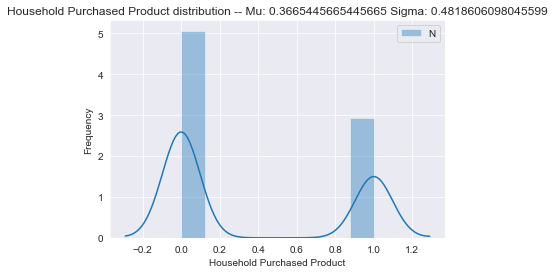

In [134]:
sns.distplot(checkpoint_3['Household Purchased Product']); # distribution plot with normalized fitting

plt.legend('Normal distribution')
plt.ylabel('Frequency')
plt.title('Household Purchased Product distribution -- Mu:' + ' ' + str(mu) + ' ' + 'Sigma:' + ' ' + str(sigma) )


    As a binary variable we wont need to standardize it

        6.3 - Checking our data correlation

In [135]:
corrmat = abs(checkpoint_3.corr()) # dataframe correlation

In [ ]:
#plt.figure(figsize=(20,20))
#sns.heatmap(corrmat, square=True, robust=True); # matrix correlation

        6.4 - Feature Selection

            6.4.1 - Pearson Correlation (Filtering Metod)

                Let's target to our objective. The prediction of the Percentage of a given Household buy a AAA product

In [138]:
k = 10 #number of variables for heatmap

cols = corrmat.nlargest(k, 'Household Purchased Product')['Household Purchased Product'].index # The tenth greater correlation columns

focus_corr = abs(np.corrcoef(checkpoint_3[cols].values.T)) # correlation calculated considering only the tenth more correlated columns

#plt.figure(figsize=(15,10))

#hm = sns.heatmap(focus_corr, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values) # correlation matrix

#plt.show()

                We have narrow down to 10 features. However, for linear regression, we still need to check intra-dependencies among those features. In here, we will consider a set of dependent variables when they have a correlation magnitude higher than 55%.

In [140]:
cols_greater = cols[1:-2]

focus_corr_greater = abs(np.corrcoef(checkpoint_3[cols_greater].values.T)) # correlation calculated considering only the tenth more correlated columns

#plt.figure(figsize=(15,10))

#hm = sns.heatmap(focus_corr_greater, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols_greater.values, xticklabels=cols_greater.values) # correlation matrix

#plt.show()

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

                As we can see, the columns Total Number of Purchased Product and Purchased Product 7 are highly correlated. Therefore, we only need to maintain one of them. In this case, we will maintain the Total Number of Purchased Product because it has a higher correlation score with the target feature than the other.

In [141]:
pearson_features = cols_greater.drop('Purchased Product 7').tolist() # saving our features selecter using the filtering method (Pearson Correlation)

            6.4.2 - Recursive Feature Elimination

                6.4.2.1 - Lets import our sklearn libraries to analyse

In [260]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

                6.4.2.2 - Create the the label data, expected output using our checkpoint3 and converting it to array

In [219]:
entry = checkpoint_3.drop(columns='Household Purchased Product').values # converting our features to be analyzed by the RFE method to array type

target = checkpoint_3['Household Purchased Product'].values # converting our target to array type

In [296]:
model = LogisticRegression(solver='lbfgs', n_jobs= 9, penalty='l2') # lbfgs solver is recommended for large datasets and we choose l1 norm for a better convergency

                6.4.2.3 - Defining Model

                6.4.2.3 - RFE experiment for multiples number of possible features

In [306]:
import numpy.matlib as matlib # for data augmentation procedure

number_possible_features = np.arange(3, 10) # list of number of possible features
           
features_list_score = [] # list to track calculated scores

selected_features = [] # list to track selected features

for n in tqdm_notebook(range(len(number_possible_features)), desc='RFE Optimum Number of Features'):

        rfe = RFE(model, number_possible_features[n]) # defining RFE experiment

        rfe.fit(MinMaxScaler().fit_transform(StandardScaler().fit_transform(entry)), target); # fitting

        temp = pd.Series(rfe.support_,  index = list(checkpoint_3.drop(columns='Household Purchased Product').columns)) # selecting RFE columns features

        tmp_selected_features = temp[temp==True].index.tolist()

        selected_features.append(tmp_selected_features) # appending to our list

        x_train, x_test, y_train, y_test = train_test_split(MinMaxScaler().fit_transform(checkpoint_3[tmp_selected_features]), target, test_size = 0.7, random_state = 42, shuffle=True)


        x2 = np.matlib.repmat(x_train, 10, 1) # as we have an imbalanced sample of classes, we perform a data augmentation procedure to avoid miss prediction

        y2 = np.matlib.repmat(y_train, 10, 1).ravel() # as we have an imbalanced sample of classes, we perform a data augmentation procedure to avoid miss prediction

        model.fit(x2, y2) # fitting the model

        tmp_score = model.score(x_test, y_test) # scoring the model 

        features_list_score.append(tmp_score) # appending to the score list
        

In [310]:
for i in range(len(selected_features)):

    print('Selected features for K =' + ' ' + str(i+3), '\n')

    print(selected_features[i], '\n')

    print('Corresponding Score:' + ' ' + str(features_list_score[i]))

Selected features for K = 3 

['Purchased Product 7', 'Purchased Product 8', 'Total Number of Purchased Products'] 

Corresponding Score: 1.0
Selected features for K = 4 

['Purchased Product 2', 'Purchased Product 7', 'Purchased Product 8', 'Total Number of Purchased Products'] 

Corresponding Score: 1.0
Selected features for K = 5 

['Purchased Product 1', 'Purchased Product 2', 'Purchased Product 7', 'Purchased Product 8', 'Total Number of Purchased Products'] 

Corresponding Score: 1.0
Selected features for K = 6 

['Purchased Product 1', 'Purchased Product 2', 'Purchased Product 5', 'Purchased Product 7', 'Purchased Product 8', 'Total Number of Purchased Products'] 

Corresponding Score: 0.9979072200906871
Selected features for K = 7 

['Purchased Product 1', 'Purchased Product 2', 'Purchased Product 3', 'Purchased Product 5', 'Purchased Product 7', 'Purchased Product 8', 'Total Number of Purchased Products'] 

Corresponding Score: 0.9996512033484478
Selected features for K = 8 



## Clustering By Household Types

In [ ]:
path_out = '..\\resources\\checkpoint.csv'
filtered_data.to_csv(path_or_buf=path_out, index=False)

        We still need to keep an eye on the variables that only have 2 unique values, but it will be more a subjective evaluation 

* Check correlation Matrix

#correlation matrix
corrmat = remove_null_data.corr()
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corrmat, square=True); # considering 70% o correlation as minimum to show

* Observations

  1- There is an "island" between Rec ID and Tow destination Longitude this will be evaluate latter, but looks promissing
  2- Basic Cost has a high correlation with the variables within this "island" 
  3- Individual Key and Right_Individual Key are pratically the same variable
  4- ZIP5 and ZIP9 are pratically the same variable
  5- Months from join to Cancel has no correlation at so ever with the Premier Cost variable
  

    By the correlation matrix of the entire dataset (minus the columns with more than 70% of null values), we can see that there are still some columns with no correlation, or total correlation with all the variables, and some trouble columns. Therefore, the best thing to do is to drop them.

trouble_columns= ['Is Duplicate', 'Member Match Flag']

columns_will_not_use = ['Individual Key', 'Member Flag', 'Right_Individual Key']